In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold, RandomizedSearchCV

In [14]:
train_rows = np.load('data/train_rows.npy')
test_rows = np.load('data/test_rows.npy')

In [15]:
X_train, y_train = train_rows[:, :-1], train_rows[:, -1]
X_test, y_test = test_rows[:, :-1], test_rows[:, -1]

### Baseline model - Random forest classifier
Using CV and hyperparameter tuning to find the best model:

In [16]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 20, 30, 40, 45, 50, 55],
    'max_leaf_nodes': [500, 600, 700, 750, 800, 850]
}

# Training via CV
model = RandomForestClassifier(random_state=0, class_weight='balanced')
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
grid_search = RandomizedSearchCV(model, param_grid, scoring="f1", n_iter=100, cv=kfold)
grid_result_RFC = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result_RFC.best_score_, grid_result_RFC.best_params_))
means_RFC = grid_result_RFC.cv_results_['mean_test_score']
stds_RFC = grid_result_RFC.cv_results_['std_test_score']
params_RFC = grid_result_RFC.cv_results_['params']

Best: 0.706858 using {'n_estimators': 200, 'max_leaf_nodes': 500, 'max_depth': 10}


#### Model performance

In [19]:
clf = RandomForestClassifier(random_state=0, class_weight='balanced', **grid_result_RFC.best_params_)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print(f'Precision on the train set: {round(precision_score(y_train, y_train_pred), 3)}')
print(f'Recall on the train set: {round(recall_score(y_train, y_train_pred), 3)}')
print(f'F1 score on the train set: {round(f1_score(y_train, y_train_pred), 3)}\n')

y_test_pred = clf.predict(X_test)
print(f'Precision on the test set: {round(precision_score(y_test, y_test_pred), 3)}')
print(f'Recall on the test set: {round(recall_score(y_test, y_test_pred), 3)}')
print(f'F1 score on the test set: {round(f1_score(y_test, y_test_pred), 3)}')

with open('Model_pickles/grid_result_RFC.pkl', 'wb') as file:
    pickle.dump(grid_result_RFC, file)

with open('Model_pickles/best_model_RFC.pkl', 'wb') as file:
    pickle.dump(clf, file)

Precision on the train set: 0.91
Recall on the train set: 0.857
F1 score on the train set: 0.882

Precision on the test set: 0.81
Recall on the test set: 0.617
F1 score on the test set: 0.7


#### Interpretability
Feature importance:

In [20]:
with open('data/features_names.pkl', 'rb') as file:
    features_names = pickle.load(file)

features_importances = sorted([(round(score, 5), name) for score, name in zip(clf.feature_importances_.tolist(), features_names)], reverse=True)
print('Top features:')
for f in features_importances[:25]:
    print(f)
print('\n')
print('least important features:')
for f in features_importances[-25:]:
    print(f)

Top features:
(0.08124, 'ICULOS_0.75')
(0.07937, 'ICULOS_1')
(0.06966, 'ICULOS_0.5')
(0.0672, 'ICULOS_mean')
(0.06315, 'ICULOS_0.25')
(0.01926, 'FiO2_miss_flag_mean')
(0.01354, 'Creatinine_miss_flag_mean')
(0.01198, 'BUN_miss_flag_mean')
(0.01111, 'Temp_1')
(0.0105, 'Potassium_miss_flag_mean')
(0.01048, 'Lactate_miss_flag_mean')
(0.01027, 'SBP_miss_flag_mean')
(0.00963, 'pH_miss_flag_mean')
(0.00958, 'Hgb_miss_flag_mean')
(0.00925, 'WBC_miss_flag_mean')
(0.00917, 'Temp_miss_flag_mean')
(0.00871, 'FiO2_mean')
(0.00797, 'Temp_mean')
(0.00779, 'PaCO2_miss_flag_mean')
(0.00738, 'Platelets_miss_flag_mean')
(0.00736, 'Resp_miss_flag_mean')
(0.00653, 'Resp_mean')
(0.00644, 'Glucose_miss_flag_mean')
(0.00632, 'Hct_0.5')
(0.00624, 'Temp_0.75')


least important features:
(2e-05, 'TroponinI_miss_flag_0.5')
(2e-05, 'SaO2_miss_flag_0.75')
(2e-05, 'Phosphate_miss_flag_0')
(2e-05, 'PaCO2_miss_flag_0.25')
(2e-05, 'PTT_miss_flag_0.5')
(2e-05, 'Magnesium_miss_flag_0.5')
(2e-05, 'Hgb_miss_flag_0.5')
(2e

In [21]:
with open('data/features_names.pkl', 'rb') as file:
    features_names = pickle.load(file)
    features_to_idx = {f: i for i, f in enumerate(features_names)}

In [22]:
missing_flag_frac_features = []
for frac in [0, 0.25, 0.5, 0.75, 1]:
    for f in features_names:
        if str(frac) in f and 'miss_flag' in f and 'mean' not in 'f':
            missing_flag_frac_features.append(f)
            
missing_rates_test = np.sum(X_test[: ,[features_to_idx[f] for f in missing_flag_frac_features]], axis=1)
idx_most_missing = np.argpartition(missing_rates_test, 1000)[:1000]
idx_least_missing = np.argpartition(missing_rates_test, -1000)[-1000:]

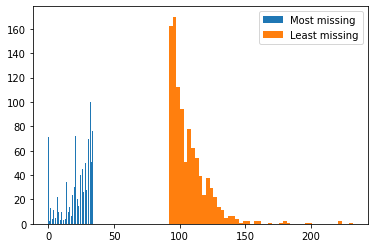

In [23]:
plt.hist(missing_rates_test[idx_most_missing], bins=50, label='Most missing')
plt.hist(missing_rates_test[idx_least_missing], bins=50, label='Least missing')
plt.legend()
plt.show()

In [24]:
y_test_pred_most_missing = clf.predict(X_test[idx_most_missing, :])
print(f'Precision on 1000 patients who have the most missing data: {round(precision_score(y_test[idx_most_missing], y_test_pred_most_missing), 3)}')
print(f'Recall on 1000 patients who have the most missing data: {round(recall_score(y_test[idx_most_missing], y_test_pred_most_missing), 3)}')
print(f'F1 on 1000 patients who have the most missing data: {round(f1_score(y_test[idx_most_missing], y_test_pred_most_missing), 3)}\n')

y_test_pred_least_missing = clf.predict(X_test[idx_least_missing, :])
print(f'Precision on 1000 patients who have the least amount of missing data: {round(precision_score(y_test[idx_least_missing], y_test_pred_least_missing), 3)}')
print(f'Recall on 1000 patients who have the least amount of missing data: {round(recall_score(y_test[idx_least_missing], y_test_pred_least_missing), 3)}')
print(f'F1 on 1000 patients who have the least amount of missing data: {round(f1_score(y_test[idx_least_missing], y_test_pred_least_missing), 3)}')

Precision on 1000 patients who have the most missing data: 0.967
Recall on 1000 patients who have the most missing data: 0.944
F1 on 1000 patients who have the most missing data: 0.955

Precision on 1000 patients who have the least amount of missing data: 0.952
Recall on 1000 patients who have the least amount of missing data: 0.608
F1 on 1000 patients who have the least amount of missing data: 0.742


In [25]:
age = X_test[:, features_to_idx['Age']]
seniors_idx = (age > 75)

print(f'Number of seniors: {len(X_test[seniors_idx])}')
y_test_pred_seniors = clf.predict(X_test[seniors_idx])
print(f'Precision on seniors (older than 75): {round(precision_score(y_test[seniors_idx], y_test_pred_seniors), 3)}')
print(f'Recall on seniors (older than 75): {round(recall_score(y_test[seniors_idx], y_test_pred_seniors), 3)}')
print(f'F1 on seniors (older than 75): {round(f1_score(y_test[seniors_idx], y_test_pred_seniors), 3)}')

Number of seniors: 2236
Precision on seniors (older than 75): 0.864
Recall on seniors (older than 75): 0.648
F1 on seniors (older than 75): 0.74


### Advanced model - XGBoost classifier
Using CV and hyperparameter tuning to find the best model:

In [31]:
from xgboost import XGBClassifier

param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'lambda': [0, 0.5, 1, 1.5, 2, 3, 4.5],
        'min_child_weight': np.arange(0.0001, 1.5, 0.001),
        'gamma': np.arange(0.0, 10.0, 0.005),
        'learning_rate': np.arange(0.09, 0.3, 0.005),
        'subsample': np.arange(0.05, 1.0, 0.04),
        'colsample_bylevel': np.round(np.arange(0.8, 1.2, 0.05)),
        'colsample_bytree': np.arange(0.8, 1.0, 0.05)}

labels, counts = np.unique(y_train, return_counts=True)
model = XGBClassifier(scale_pos_weight=counts[0]/counts[1])
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
grid_search = RandomizedSearchCV(model, param_grid, scoring="f1", n_iter=300, cv=kfold)
grid_result_XGB = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result_XGB.best_score_, grid_result_XGB.best_params_))
means_XGB = grid_result_XGB.cv_results_['mean_test_score']
stds_XGB = grid_result_XGB.cv_results_['std_test_score']
params_XGB = grid_result_XGB.cv_results_['params']

Best: 0.760867 using {'subsample': 0.9699999999999999, 'min_child_weight': 0.9281, 'max_depth': 10, 'learning_rate': 0.14500000000000005, 'lambda': 3, 'gamma': 6.11, 'colsample_bytree': 0.8500000000000001, 'colsample_bylevel': 1.0}


#### Model performance

In [33]:
model = XGBClassifier(scale_pos_weight=counts[0]/counts[1], **grid_result_XGB.best_params_)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=1,
              colsample_bytree=0.8500000000000001, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=6.11, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=3,
              learning_rate=0.14500000000000005, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=0.9281, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [34]:
y_train_pred = model.predict(X_train)
print(f'Precision on the train set: {round(precision_score(y_train, y_train_pred), 3)}')
print(f'Recall on the train set: {round(recall_score(y_train, y_train_pred), 3)}')
print(f'F1 score on the train set: {round(f1_score(y_train, y_train_pred), 3)}\n')

y_test_pred = model.predict(X_test)
print(f'Precision on the test set: {round(precision_score(y_test, y_test_pred), 3)}')
print(f'Recall on the test set: {round(recall_score(y_test, y_test_pred), 3)}')
print(f'F1 score on the test set: {round(f1_score(y_test, y_test_pred), 3)}')

with open('Model_pickles/grid_result_XGB.pkl', 'wb') as file:
    pickle.dump(grid_result_XGB, file)

with open('Model_pickles/best_model_XGB.pkl', 'wb') as file:
    pickle.dump(model, file)

Precision on the train set: 0.972
Recall on the train set: 1.0
F1 score on the train set: 0.986

Precision on the test set: 0.818
Recall on the test set: 0.706
F1 score on the test set: 0.758


#### Interpretability
Feature importance:

In [35]:
features_importances = sorted([(round(score, 5), name) for score, name in zip(model.feature_importances_.tolist(), features_names)], reverse=True)
print('Top features:')
for f in features_importances[:25]:
    print(f)
print('\n')
print('least important features:')
for f in features_importances[-25:]:
    print(f)

Top features:
(0.05964, 'ICULOS_0.75')
(0.04694, 'ICULOS_1')
(0.01476, 'FiO2_miss_flag_mean')
(0.0145, 'PaCO2_miss_flag_1')
(0.01389, 'EtCO2_miss_flag_1')
(0.0107, 'Hgb_miss_flag_0')
(0.01058, 'Lactate_miss_flag_mean')
(0.00984, 'Hct_miss_flag_0.75')
(0.00956, 'Unit2_0')
(0.00863, 'Temp_1')
(0.00862, 'DBP_miss_flag_0.25')
(0.00724, 'WBC_miss_flag_0.5')
(0.00685, 'FiO2_miss_flag_1')
(0.00685, 'DBP_miss_flag_0.5')
(0.00655, 'SaO2_miss_flag_0.5')
(0.00653, 'AST_mean')
(0.0065, 'Alkalinephos_miss_flag_mean')
(0.00629, 'BUN_0.75')
(0.00619, 'SBP_miss_flag_mean')
(0.00616, 'Fibrinogen_0.25')
(0.00597, 'HR_miss_flag_1')
(0.00552, 'SaO2_miss_flag_0')
(0.00548, 'SBP_miss_flag_0.5')
(0.00545, 'Fibrinogen_mean')
(0.00529, 'Alkalinephos_0.5')


least important features:
(0.0, 'Bilirubin_direct_miss_flag_0.25')
(0.0, 'Bilirubin_direct_miss_flag_0')
(0.0, 'Bilirubin_direct_mean')
(0.0, 'Bilirubin_direct_1')
(0.0, 'Bilirubin_direct_0.75')
(0.0, 'Bilirubin_direct_0.5')
(0.0, 'Bilirubin_direct_0.25')
(

In [36]:
y_test_pred_most_missing = model.predict(X_test[idx_most_missing, :])
print(f'Precision on 1000 patients who have the most missing data: {round(precision_score(y_test[idx_most_missing], y_test_pred_most_missing), 3)}')
print(f'Recall on 1000 patients who have the most missing data: {round(recall_score(y_test[idx_most_missing], y_test_pred_most_missing), 3)}')
print(f'F1 on 1000 patients who have the most missing data: {round(f1_score(y_test[idx_most_missing], y_test_pred_most_missing), 3)}\n')

y_test_pred_least_missing = model.predict(X_test[idx_least_missing, :])
print(f'Precision on 1000 patients who have the least amount of missing data: {round(precision_score(y_test[idx_least_missing], y_test_pred_least_missing), 3)}')
print(f'Recall on 1000 patients who have the least amount of missing data: {round(recall_score(y_test[idx_least_missing], y_test_pred_least_missing), 3)}')
print(f'F1 on 1000 patients who have the least amount of missing data: {round(f1_score(y_test[idx_least_missing], y_test_pred_least_missing), 3)}')

Precision on 1000 patients who have the most missing data: 0.968
Recall on 1000 patients who have the most missing data: 0.976
F1 on 1000 patients who have the most missing data: 0.972

Precision on 1000 patients who have the least amount of missing data: 0.89
Recall on 1000 patients who have the least amount of missing data: 0.753
F1 on 1000 patients who have the least amount of missing data: 0.816


In [37]:
print(f'Number of seniors: {len(X_test[seniors_idx])}')
y_test_pred_seniors = model.predict(X_test[seniors_idx])
print(f'Precision on seniors (older than 75): {round(precision_score(y_test[seniors_idx], y_test_pred_seniors), 3)}')
print(f'Recall on seniors (older than 75): {round(recall_score(y_test[seniors_idx], y_test_pred_seniors), 3)}')
print(f'F1 on seniors (older than 75): {round(f1_score(y_test[seniors_idx], y_test_pred_seniors), 3)}')

Number of seniors: 2236
Precision on seniors (older than 75): 0.867
Recall on seniors (older than 75): 0.739
F1 on seniors (older than 75): 0.798


In [ ]:
with open('Model_pickles/best_model_XGB.pkl', 'rb') as file:
    mo = pickle.load(file)

y_test_pred = mo.predict(X_test)
print(f'Precision on the test set: {round(precision_score(y_test, y_test_pred), 3)}')
print(f'Recall on the test set: {round(recall_score(y_test, y_test_pred), 3)}')
print(f'F1 score on the test set: {round(f1_score(y_test, y_test_pred), 3)}')


Precision on the test set: 0.818
Recall on the test set: 0.706
F1 score on the test set: 0.758
